# SI: Anomalous Protein-Protein Interactions in Multivalent Salt Solution

*Coralie Pasquier, Mario Vazdar, Jan Forsman, and Mikael Lund, 2017*

This notebook enables you to simulate two human serum albumin (HSA) molecules in a cylindrical box in the presence of explicit trivalent salt ions (yttrium).
The proteins move along the z-axis of a confining cylinder, while the ions move freely.
The molecules interact via a combined Debye-Huckel/Lennard-Jones potential and during simulation, the protein-protein pair correlation function is calculated and eventually plotted.

You may choose to have only the yttrium ions as explicit in the box and the monovalent ions only accounted for through the Debye length, or all the ions (yttrium, chloride, sodium) explicitly.

<img src='pmf/snapshot.png' style="width: 800px;"/>

### System Requirements

This Jupyter Notebook was originally run on MacOS 12.10 / Ubuntu 16.04 using Continuum Analytics _Anaconda_. The Anaconda environment can be generated using the following commands, assuming Miniconda has already been installed:
```bash
conda create --name SIenv python=3 matplotlib=1.5.3 scipy=0.18.1 pandas=0.19.1 notebook=4.2.3
source activate SIenv
```

## Import modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
import math
from math import sqrt, log, pi, exp, sinh
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
print(workdir)

/Users/mikael/github/SI-proteins_in_multivalent_electrolyte


## Setup

In [2]:
# Conditions
extrasalt  = [0, 0.1, 0.2]                            # 1:1 background contribution to ionic strength (mol/l)
numberlist =  [1, 8, 16, 160]                         # Number of yttrium ions
saltlist = ["implicit"]#, "implicit"]                 # Choose if Cl and Na ions are implicit or explicit
typeljlist = ["specific"]#, "nonspecific"]            # Choose if there is an additional custom attraction

# Equilibration and production runs
runeq   = False
runprod = False

## Compiling Faunus

In [3]:
%%bash -s "$workdir"
cd $1
echo 'fau_example(twobody "./" twobody.cpp)' > pmf/CMakeLists.txt

if [ ! -d "faunus" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout bdf6c7f7
else
    cd faunus
fi
CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=$1/pmf &>/dev/null
make twobody -j4
cd $1

[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target twobody


The following is used if you're running this notebook on a slurm-enabled cluster, i.e. when submitting using the `sbatch` command.

In [4]:
%%writefile $workdir/pmf/submit.sh
#!/bin/bash
# slurm submit script if running on cluster
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 168:00:00
../twobody > out

Overwriting /Users/mikael/github/SI-proteins_in_multivalent_electrolyte/pmf/submit.sh


## Metropolis Monte Carlo Simulation

Several options are available:

**Explicit or implicit Na+ and Cl-:** Yttrium will always be explicit in the simulations. But you can choose the Na+ and Cl- counterions to be:
- Implicit (<font color='green'> saltlist = ["implicit"] </font>): only yttrium ions are in the box, and the ionic strength is calculated to take into account the protein counterions and the chloride coming from YCl3;
- Explicit (<font color='green'> saltlist = ["explicit"] </font>): yttrium, chloride (from YCl3) and sodium (protein counterions) ions are added in the box and the ionic strength is set to a very low value (1e-20 M).

**Specific or non-specific interactions:** You can choose to give yttrium specific interactions with the carboxylic groups of the protein. In this case, use <font color='green'> typeljlist = ["specific"] </font> (otherwise, use <font color='green'> typeljlist = ["nonspecific"] </font>).

**Equilibration and production runs:** To run the equilibration and production runs, set <font color='green'> runeq </font> and <font color='green'> runprod </font> to <font color='green'> True </font>, repectively.
<br />
<br />
<br />
**- - - - Note on the output files - - - -** 
<font color='#0000cc'> eq, out </font>: simulation standard output for the equilibration and production runs, respectively. <br />
<font color='#0000cc'> rdf.dat </font>: radial distribution function of the proteins. <br />
<font color='#0000cc'> confout.pqr </font>: PQR file for vizualization of the system in the final state (ex. with VMD). 

In [9]:
def mkinput():
    
    # Determines which ions are going to be in the box
    if salt=="implicit": 
        gsalt = {
            "protein":  { "structure":"../hsa-ph7.aam", "Ninit":2, "insdir":"0 0 1" },
            "yttrium": {"atoms":"Yt", "atomic":True, "Ninit":Nyt }
        }
        tsalt = {
            "yttrium" : { "prob":1.0, "peratom":True }
        }
            
    if salt=="explicit": 
        gsalt = {
            "protein":  { "structure":"../hsa-ph7.aam", "Ninit":2, "insdir":"0 0 1" },
            "yttrium": {"atoms":"Yt Cl Cl Cl", "atomic":True, "Ninit":Nyt },
            "sodium": {"atoms":"Na", "atomic":True, "Ninit":Nna }
        }
        tsalt = {
            "yttrium" : { "prob":1.0, "peratom":True },
            "sodium" : { "prob":1.0, "peratom":True }
        }
            
    
    # Custom LJ parameters for specific ion-residue interaction
    if typelj=="specific": 
        clj = {      
                "Yt ASP" : { "sigma":2.2, "eps":epc },
                "Yt GLU" : { "sigma":2.2, "eps":epc },
                "Yt CTR" : { "sigma":2.2, "eps":epc }
            }
    if typelj=="nonspecific": 
        clj = {}
        
    # List of atoms, etc.       
    mk = {
        "customlj" : clj ,    
        "energy" : {
            "nonbonded" : {
                "coulomb" : { "epsr" : 78.7, "ionicstrength" : I }
                },
            },
        "atomlist" : {
            "H3PO4":  { "eps":eps, "q":0,  "r":2.0 },
            "H2PO4":  { "eps":eps, "q":-1, "r":2.0 },
            "HPO4" :  { "eps":eps, "q":-2, "r":2.0 },
            "PO4"  :  { "eps":eps, "q":-3, "r":2.0 },
            "BPTI" :  { "eps":eps, "q":7.3, "r":12.29 },
            "Na"   :  { "eps":epsion, "q": 1, "r":1.9, "mw":22.99, "dp":dps },
            "Cl"   :  { "eps":epsion, "q":-1, "r":1.7, "mw":35.45, "dp":dpyt },
            "I"    :  { "eps":eps, "q":-1, "r":2.0, "mw":1 },
            "SCN"  :  { "eps":eps, "q":-1, "r":2.0, "mw":1 },
            "ASP"  :  { "eps":eps, "q":-1, "r":3.6, "mw":110 },
            "HASP" :  { "eps":eps, "q":0,  "r":3.6, "mw":110 },
            "LASP" :  { "eps":eps, "q":2,  "r":3.6, "mw":110 },
            "CTR"  :  { "eps":eps, "q":-1, "r":2.0, "mw":16 },
            "HCTR" :  { "eps":eps, "q":0,  "r":2.0, "mw":16 },
            "GLU"  :  { "eps":eps, "q":-1, "r":3.8, "mw":122 },
            "HGLU" :  { "eps":eps, "q":0,  "r":3.8, "mw":122 },
            "LGLU" :  { "eps":eps, "q":2,  "r":3.8, "mw":122 },
            "HIS"  :  { "eps":eps, "q":0,  "r":3.9, "mw":130 },
            "HHIS" :  { "eps":eps, "q":1,  "r":3.9, "mw":130 },
            "NTR"  :  { "eps":eps, "q":0,  "r":2.0, "mw":14 },
            "HNTR" :  { "eps":eps, "q":1,  "r":2.0, "mw":14 },
            "TYR"  :  { "eps":eps, "q":-1, "r":4.1, "mw":154 },
            "HTYR" :  { "eps":eps, "q":0,  "r":4.1, "mw":154 },
            "LYS"  :  { "eps":eps, "q":0,  "r":3.7, "mw":116 },
            "HLYS" :  { "eps":eps, "q":1,  "r":3.7, "mw":116 },
            "CYS"  :  { "eps":eps, "q":0, "r":3.6, "mw":103 },
            "CYF"  :  { "eps":eps, "q":-1, "r":3.6, "mw":103 },
            "HCYS" :  { "eps":eps, "q":0,  "r":3.6, "mw":103 },
            "ARG"  :  { "eps":eps, "q":0,  "r":4.0, "mw":144 },
            "HARG" :  { "eps":eps, "q":1,  "r":4.0, "mw":144 },
            "ALA"  :  { "eps":eps, "q":0,  "r":3.1, "mw":66 },
            "ILE"  :  { "eps":eps, "q":0,  "r":3.6, "mw":102 },
            "LEU"  :  { "eps":eps, "q":0,  "r":3.6, "mw":102 },
            "MET"  :  { "eps":eps, "q":0,  "r":3.8, "mw":122 },
            "PHE"  :  { "eps":eps, "q":0,  "r":3.9, "mw":138 },
            "PRO"  :  { "eps":eps, "q":0,  "r":3.4, "mw":90 },
            "TRP"  :  { "eps":eps, "q":0,  "r":4.3, "mw":176 },
            "VAL"  :  { "eps":eps, "q":0,  "r":3.4, "mw":90 },
            "SER"  :  { "eps":eps, "q":0,  "r":3.3, "mw":82 },
            "THR"  :  { "eps":eps, "q":0,  "r":3.5, "mw":94 },
            "ASN"  :  { "eps":eps, "q":0,  "r":3.6, "mw":108 },
            "GLN"  :  { "eps":eps, "q":0,  "r":3.8, "mw":120 },
            "GLY"  :  { "eps":eps, "q":0,  "r":2.9, "mw":54 },
            "SPH"  :  { "eps":eps, "q":1,  "r":3.0, "mw":30 },
            "CA"   :  { "eps":eps, "q":2,  "r":2.12, "mw":40.08}, 
            "CYT"  :  { "eps":eps, "q":0, "r":3.6, "mw":103 }, 
            "Yt"   :  { "eps":epsion, "q":3, "r":0.0, "mw":88, "dp":dpyt }
            },
        "processes" : {
            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH },
            "K1"    : { "bound":"H3PO4", "free":"H2PO4","pKd":2.12,  "pX":pH },
            "K2"    : { "bound":"H2PO4", "free":"HPO4", "pKd":7.21,  "pX":pH },
            "K3"    : { "bound":"HPO4",  "free":"PO4",  "pKd":12.67, "pX":pH }
        },
        
        "moleculelist": gsalt,
        
        "moves" : {
            "atomtranslate" : tsalt,
            "moltransrotcluster" : { 
                "protein" : { "dp":dpp, "dprot":drot, "prob":1.0, "permol":True, "dir":"0 0 1", "threshold":6, 
                             "clustergroup":"yttrium" }
            } 
        },
        
        "system" : {
            "temperature" : temp,
            "cylinder" : { "length" : clen, "radius" : crad },
            "mcloop"   : { "macro" : 10, "micro" : micro }
        }
    }
    with open('hsa.json', 'w+') as f:
        f.write(json.dumps(mk, indent=4))

N_A = 6.02214129*1e+23

# Defines the number of each ion in the box
def setions():
    global Nyt, Nna, I
    if salt=="implicit":
        Nyt = Ns
        I = impl
    if salt=="explicit":
        Nyt = Ns
        Nna = 16
        I = 1e-20
        
# Defines custom displacement parameters
def setdp():
    global dpp,drot,dps,dpyt 
    if salt=="implicit":
        if (Ns >=1 and Ns < 35):     
            dpp, drot, dps, dpyt = 80, 6, 70, 70
        elif (Ns >=35 and Ns < 60):
            dpp, drot, dps, dpyt = 40, 3, 70, 70
        elif (Ns >=60 and Ns < 180):
            dpp, drot, dps, dpyt = 20, 1, 70, 70
        else:
            dpp, drot, dps, dpyt = 20, 1, 70, 70
    if salt=="explicit":
        if (Ns >=1 and Ns < 10):
            dpp, drot, dps, dpyt = 80, 5, 80, 50
        else:
            dpp, drot, dps, dpyt = 20, 3, 80, 30
                
# Other parameters
pH   = 7.0
temp = 298.15
kT   = (1.3806*10**-23)*(6.022*10**23)*temp/1000   #kJ/mol

eps=0.05*kT                           # Epsilons for Lennard-Jones interaction (kJ/mol)
epsion=eps/10
epc=1.6*kT

clen = 563                            # Box length
crad = 50                             # Box radius
V = (math.pi*(crad**2)*clen)*1e-27    # Box volume

# Number of loops for equilibration and production runs
micro_eq   = 100000
micro_prod = 10000000

# Let's begin the simulation!
%cd -q $workdir'/pmf'
if os.path.isfile('monte-carlo-data.p'): # but only if we don't have data already
    print('No need to run simulation -- we have data file')
else:
    for Cs in extrasalt:
        for salt in saltlist:
            for Ns in numberlist:
                for typelj in typeljlist:
                    Cc = ((3*Ns + 16)/N_A)/V              # Concentration of Na, Cl in M
                    impl = 0.5*Cc                         # Implicit ionic strength in M (if relevant)
                    impl += Cs                            # Add extra salt if needed
                    setions()
                    pfx='Ns'+str(Ns)+'-'+str(salt)+'-'+str(typelj)+'-Cs'+str(Cs)     # Name of the subfolders
                    if not os.path.isdir(pfx):
                        %mkdir -p $pfx    
                    %cd $pfx
                    setdp()
                    if runeq:
                        try:
                            os.remove('state')
                        except: pass
                        micro = micro_eq
                        mkinput()
                        !../twobody > eq          # local equilibration runs
                    if runprod:
                        micro = micro_prod
                        mkinput()
                        if shutil.which('sbatch') is not None:
                            !sbatch ../submit.sh  # run on slurm cluster?
                        else:
                            !../twobody > out     # ...else run locally (time consuming!)

                    %cd -q ..

No need to run simulation -- we have data file


## Load potential of mean force from simulation output

The script will loop through the folders corresponding to the desired conditions, calculate the potentials of mean force (PMF) from the distribution functions and plot them on a single graph. A Pandas object containing all data will be saved to disk (in _pickle_ format)

In [6]:
%cd -q $workdir'/pmf'
d = {}
if Path('monte-carlo-data.p').is_file():  # do we have a data file?
    d = pd.read_pickle('monte-carlo-data.p')
else:                                     # if not, create one from simulation data...
    for Cs in extrasalt:
        d[Cs] = {}
        for salt in saltlist:
            d[Cs][salt] = {}
            for typelj in typeljlist:
                d[Cs][salt][typelj] = {}
                for Ns in numberlist:
                    pfx='Ns'+str(Ns)+'-'+str(salt)+'-'+str(typelj)+'-Cs'+str(Cs)
                    if Path(pfx+'/rdf.dat').is_file(): #if os.path.isdir(pfx):
                        %cd $pfx
                        r, g = np.loadtxt("rdf.dat", usecols=(0,1), unpack=True)
                        g = g / g[r>250].mean()

                        M = Ns/V * 1661e-24 # molar concentration
                        label = '$c_s$=' + ("%.0f" % M) + ' mM'  # label used when plotting

                        d[Cs][salt][typelj][Ns] = dict([ ('r', r), ('pmf',-np.log(g)), ('label',label)])

                        %cd -q ..
                d[Cs][salt][typelj] = pd.DataFrame( d[Cs][salt][typelj] ) # convert dict -> pandas 
        d[Cs][salt] = pd.Series(d[Cs][salt])
    d = pd.DataFrame(d)
    d.to_pickle('monte-carlo-data.p')

d[0.2].implicit.specific

,1,8,16,160
label,$c_s$=0 mM,$c_s$=3 mM,$c_s$=6 mM,$c_s$=60 mM
pmf,"[0.296644907046, 6.69431502879, 1.31441767525,...","[4.66043106684, 1.745197334, 6.33440750041, 4....","[0.713347672422, 5.3892869293, 0.480561321702,...","[6.452490899, 5.80190333286, 7.32795963635, 8...."
r,"[40.2, 40.4, 40.6, 40.8, 41.0, 41.2, 41.4, 41....","[40.2, 40.6, 40.8, 41.0, 41.2, 41.4, 41.6, 41....","[39.0, 39.2, 39.8, 40.2, 40.4, 40.8, 41.0, 41....","[39.4, 39.6, 40.2, 40.4, 40.6, 40.8, 41.0, 41...."


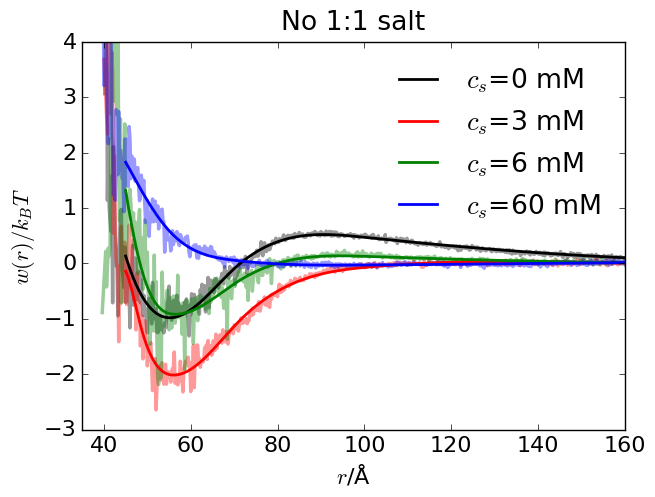

In [7]:
from scipy.interpolate import UnivariateSpline
plt.rcParams.update({'font.size': 16, 'figure.figsize': [7.0, 5.0]})

def plotpmf( data ):
    factor = [40, 40, 60, 40] # spline smoothing factor
    colors = ['black', 'red', 'green', 'blue']
    icol=0
    for Ns, i in data.iteritems(): # loop over M+++ concentrations

        smooth = factor[icol]
        col = colors[icol]
        icol += 1

        rr = np.linspace(45, 160, 1000)
        spl = UnivariateSpline(i.r, i.pmf, k=3)
        spl.set_smoothing_factor( smooth )

        plt.plot( i.r, i.pmf, '-', color=col, lw=2.5, markevery=1, zorder=1, alpha=0.4)
        plt.plot( rr, spl(rr), color=col, lw=2, zorder=2, label=i.label )

    plt.xlabel(r'$r$/Å')
    plt.ylabel(r'$w(r)/k_BT$')
    plt.xlim(35, 160)
    plt.ylim(-3, 4)
    plt.legend(loc=0, frameon=False)

plt.title('No 1:1 salt', verticalalignment='bottom')
plotpmf( d[0].implicit.specific )
plt.savefig('pmf-0mM.pdf', bbox_inches='tight')

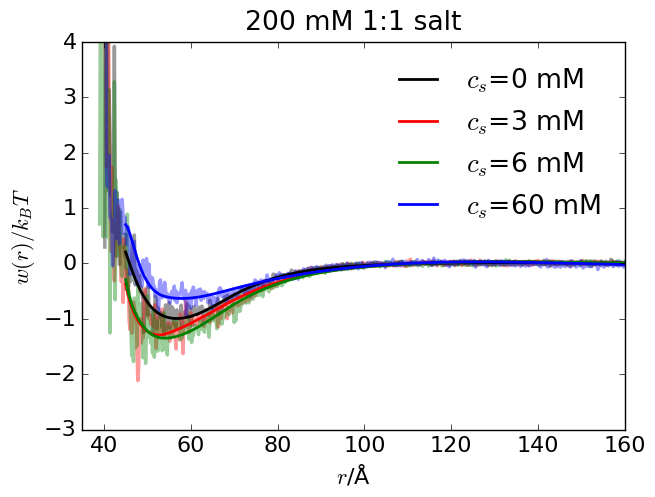

In [8]:
plt.title('200 mM 1:1 salt', verticalalignment='bottom')
plotpmf( d[0.2].implicit.specific )
plt.savefig('pmf-200mM.pdf', bbox_inches='tight')